## SOURCES: 
https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/ for outline of ResNet architecture.
https://github.com/kuangliu/pytorch-cifar A repo showing various ResNets trained from scratch on CIFAR-10.

Imports, config:

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data:
Data will be normalized using torchvision.transforms.normalize. 
Data processed in batches of 64, with 10% being used for validation.

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=0,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            #transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## The dataset
Below shows some sample images of and the corresponding labels from the CIFAR10 dataset. One notable aspect of this dataset is that all the images are relatively low resolution (32x32). src: https://www.cs.toronto.edu/~kriz/cifar.html

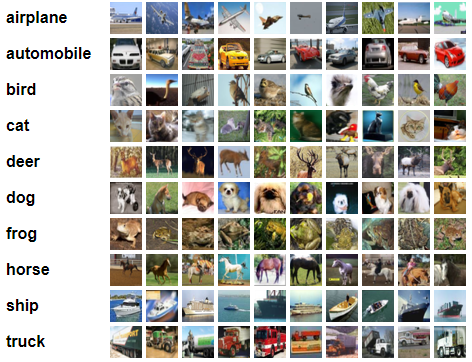

## Residual Block:

Residual Block setup (https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/). Uses skipped connection with the optional for downsampling. Self.conv1 contains the ReLU F(x), and self.conv2 is the skip connection S(x), for the combined effect of ReLU(S(x) + F(x)) when forwarding.

In [3]:
#2
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# Construct the ResNet
Below defines the ResNet architecture: A convolutional layer of kernal size 4, followed by batch normalization layer. Then, their are 4 layers with 2 ResNet blocks each, sizes 64, 128, 128 and 256 respectively with all but the first having a stride of 2. Finally, a linear layer is used to get activation for each class at the end of the model.

In [5]:
#2
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Some additional hyperparameters are assigned here; Batch size is set to 64, and learning rate is set to 0.005. These were selected after some trial-and-error adjusting and this model seemed particularly sensitive to different learning rates.

In [6]:
num_classes = 10
num_epochs = 200
batch_size = 64
learning_rate = 0.005

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

## Model parameters
Ensure total number of trainable parameters does not exceed 5 million. The parameter count for this configuration is 3.3 million.

In [7]:
next(iter(train_loader))[0].size()

torch.Size([64, 3, 32, 32])

In [8]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]           3,072
       BatchNorm2d-2           [-1, 64, 31, 31]             128
            Conv2d-3           [-1, 64, 31, 31]          36,864
       BatchNorm2d-4           [-1, 64, 31, 31]             128
            Conv2d-5           [-1, 64, 31, 31]          36,864
       BatchNorm2d-6           [-1, 64, 31, 31]             128
        BasicBlock-7           [-1, 64, 31, 31]               0
            Conv2d-8           [-1, 64, 31, 31]          36,864
       BatchNorm2d-9           [-1, 64, 31, 31]             128
           Conv2d-10           [-1, 64, 31, 31]          36,864
      BatchNorm2d-11           [-1, 64, 31, 31]             128
       BasicBlock-12           [-1, 64, 31, 31]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Training
Train for 200 epochs, tracking validation accuracy as we go. In hindsight, early stopping would've been good to implement here too, as the final test acc. is lower than one seen along the training process, but the 5 hour train time means I didn't get chance to retrain with early stopping enabled.

In [9]:
import gc
total_step = len(train_loader)
valid_accs = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
        valid_accs.append(100 * correct / total) 

Epoch [1/200], Loss: 1.0514
Accuracy of the network on the 5000 validation images: 63.8 %
Epoch [2/200], Loss: 1.0905
Accuracy of the network on the 5000 validation images: 74.06 %
Epoch [3/200], Loss: 0.5976
Accuracy of the network on the 5000 validation images: 76.66 %
Epoch [4/200], Loss: 0.4491
Accuracy of the network on the 5000 validation images: 79.64 %
Epoch [5/200], Loss: 0.5995
Accuracy of the network on the 5000 validation images: 79.66 %
Epoch [6/200], Loss: 0.1099
Accuracy of the network on the 5000 validation images: 80.58 %
Epoch [7/200], Loss: 0.0876
Accuracy of the network on the 5000 validation images: 79.2 %
Epoch [8/200], Loss: 0.0563
Accuracy of the network on the 5000 validation images: 80.02 %
Epoch [9/200], Loss: 0.6597
Accuracy of the network on the 5000 validation images: 79.34 %
Epoch [10/200], Loss: 0.0597
Accuracy of the network on the 5000 validation images: 79.52 %
Epoch [11/200], Loss: 0.1109
Accuracy of the network on the 5000 validation images: 80.28 %

Final test on 10000 unseen samples; accuracy is 82.4% which is not terrible but not as good as was seen on the validation set at points in the training.

In [10]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 82.4 %


## Training analysis
Here we can see validation accuracy by epoch, and how there were several places we could've stopped to have >87% valid accuracy if early stopping was enabled. The frequent decreases could be indicative of a particularly complex gradient, but in this case I think it more likely that learning rate was set too high.

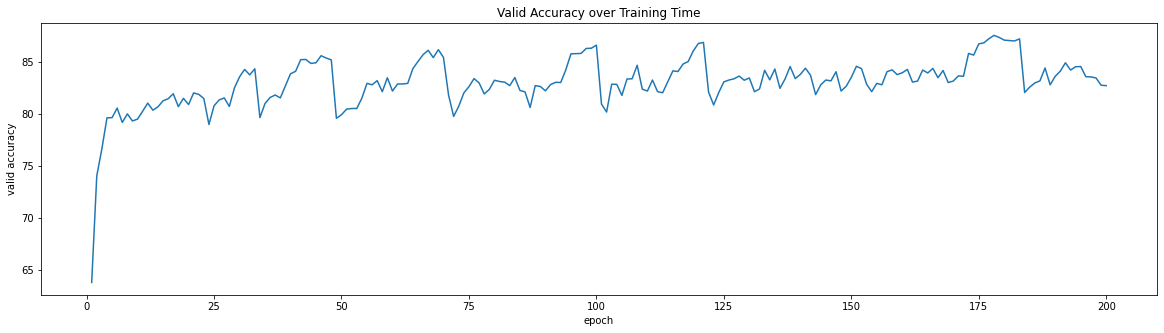

In [27]:
epochs = [*range(1,201)]

plt.rcParams["figure.figsize"] = (20,5)
plt.plot(epochs, valid_accs)
plt.xlabel("epoch")
plt.ylabel("valid accuracy")
plt.title("Valid Accuracy over Training Time")
plt.show()


## Sample predictions
Below shows the confusion matrix for all the classes in the dataset.

In [36]:
with torch.no_grad():
    predictions = []
    trues = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions += predicted.tolist()
        trues += labels.tolist()
        del images, labels, outputs
    print(predictions)
    print(trues)

[6, 9, 8, 2, 1, 5, 3, 5, 3, 7, 9, 6, 3, 8, 3, 9, 7, 4, 2, 7, 4, 6, 5, 6, 8, 3, 0, 4, 1, 4, 4, 9, 5, 9, 2, 2, 0, 7, 4, 3, 6, 4, 7, 6, 2, 8, 4, 8, 0, 2, 3, 7, 5, 2, 6, 2, 7, 0, 8, 0, 6, 0, 5, 9, 0, 1, 3, 8, 0, 3, 5, 5, 0, 9, 2, 5, 6, 4, 1, 8, 2, 8, 5, 4, 6, 9, 2, 1, 7, 2, 2, 6, 0, 6, 6, 7, 2, 0, 4, 9, 5, 2, 4, 9, 8, 0, 8, 9, 1, 7, 3, 5, 3, 8, 6, 7, 1, 7, 6, 2, 2, 7, 7, 1, 1, 8, 8, 0, 1, 6, 1, 8, 6, 0, 3, 5, 2, 5, 2, 6, 1, 5, 0, 9, 2, 7, 4, 5, 4, 4, 9, 5, 2, 7, 8, 0, 7, 6, 7, 9, 4, 5, 1, 6, 1, 9, 9, 6, 1, 5, 2, 5, 6, 8, 2, 5, 0, 9, 6, 1, 2, 7, 3, 4, 9, 6, 3, 6, 2, 3, 0, 1, 8, 9, 7, 8, 2, 8, 2, 3, 6, 3, 3, 9, 7, 1, 9, 4, 6, 7, 8, 4, 1, 0, 6, 8, 2, 8, 7, 1, 7, 6, 2, 5, 0, 3, 8, 8, 0, 8, 6, 6, 5, 8, 2, 1, 2, 2, 5, 4, 0, 6, 5, 5, 0, 1, 5, 9, 5, 1, 1, 4, 2, 2, 9, 0, 0, 5, 6, 4, 0, 9, 4, 4, 6, 3, 7, 6, 5, 1, 0, 8, 7, 8, 3, 1, 3, 2, 2, 2, 6, 4, 6, 6, 7, 2, 9, 5, 3, 7, 8, 6, 0, 6, 9, 3, 0, 1, 8, 2, 6, 2, 6, 4, 8, 9, 4, 7, 5, 7, 9, 3, 0, 2, 9, 8, 6, 2, 5, 8, 9, 1, 8, 1, 4, 1, 3, 4, 6, 3, 6, 3, 2, 

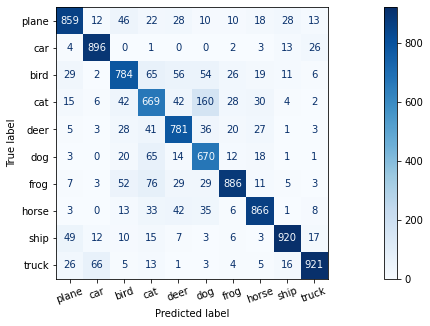

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]
confusion_matrix = confusion_matrix(predictions, trues)
cm = ConfusionMatrixDisplay(confusion_matrix, display_labels = classes)
cm.plot(values_format = 'd', cmap = 'Blues')
plt.xticks(rotation = 20)
plt.show()